# Processing of ARIS data for Benchmarking Script

Looking at the Fairbanks script, these are the fields that are necessary to do the benchmarking:

'Site ID':  This was a 4 letter code identifying the particular facility.  It doesn't have to be a 4-letter code for ARIS, just some unique ID.  
'From':  The start date of the billing period.  Any date format works.  
'Thru':  The end date of the billing period.  This could be multiple months after the start date in the case of oil or propane.  
'Service Name': This was ['Oil #1', 'Oil #2', 'Electricity', 'Steam', 'Natural Gas', 'Water', 'Sewer', 'Refuse'] for FNSB.  
'Item Description':  This was the description of the particular line item on the bill, like "Customer Charge", "Cost Adjustments", "Demand Charge" plus a very wide variety of other types of charges.  In the script, I combined all the miscellaneous charges into "Other Charge".  These were billing line items that had no Usage associated with them.  
'Usage': For usage-based charges, like kWh, kW, gallons, etc, this contains the usage.  For "Other Charges" (fixed charges), this is blank.  
'Cost': $ cost of the line item.  
'Units': For Usage based charges, the units.  These are what was in the Fairbanks data:  'Gallons', 'kWh', 'klbs', 'lbs', 'MMBtu', 'kVAR', 'kW', 'CCF', 'kVARh', 'Loads', 'Cgallons', 'kGal', 'Tons'.    

So if we can get the ARIS data into this format, and if we could keep Service Name, Units, and some of the Item Descriptions the same, the script should run.  As far as Item descriptions that need to stay the same, I think it is just peak Electric Demand that  needs to be labeled like Fairbanks.  It can be any one of the following:  'KW Charge', 'On peak demand', 'Demand Charge'


## To Do

* Standardize values in each field to match FNSB values
* Think more about how long of a billing period is too long.
* Should check the Meter Read Date Field instead of always assuming the 15th.
* Split `Other_Building_Data.xlsx` into separate Building Excel file and Fuel Types Excel file.
* Auto-generate the Building Excel file from the API data.  Map "Building Usage Name" to "Primary Function", and "Building Owner Name" to "Site Category".
    * Map each City to a Degree-Day site.
* Add a section to the Settings File to accomodate ARIS passwords/URL and other ARIS specific settings.
* Incorporate new graphs into the `benchmark.py` script, including creation of new Template.

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta

###################### Matplotlib #######################
# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [102]:
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [103]:
df = pd.read_csv("aris_benchmark_data_from_api.csv", parse_dates=['UsageDate'])
df.head()

,Unnamed: 0,BuildingId,EnergyTypeId,EnergyUnitId,EnergyUnitTypeName,EnergyTypeName,UsageDate,EnergyQuantity,DollarCost,DemandUse,DemandCost,UsageYear,MeterReadDate
0,0,44,1,1,kWh,Electric,2009-01-01,412.0,81.0,NaN,NaN,2009,NaN
1,1,44,1,1,kWh,Electric,2009-02-01,538.0,99.0,NaN,NaN,2009,NaN
2,2,44,1,1,kWh,Electric,2009-03-01,432.0,81.0,NaN,NaN,2009,NaN
3,3,44,1,1,kWh,Electric,2009-04-01,406.0,78.0,NaN,NaN,2009,NaN
4,4,44,1,1,kWh,Electric,2009-05-01,771.0,116.0,NaN,NaN,2009,NaN


In [104]:
# Get rid of unneeded columns
df.drop(columns=['Unnamed: 0', 'EnergyTypeId', 'EnergyUnitId', 'UsageYear', 'MeterReadDate'], inplace=True)
df.head()

,BuildingId,EnergyUnitTypeName,EnergyTypeName,UsageDate,EnergyQuantity,DollarCost,DemandUse,DemandCost
0,44,kWh,Electric,2009-01-01,412.0,81.0,NaN,NaN
1,44,kWh,Electric,2009-02-01,538.0,99.0,NaN,NaN
2,44,kWh,Electric,2009-03-01,432.0,81.0,NaN,NaN
3,44,kWh,Electric,2009-04-01,406.0,78.0,NaN,NaN
4,44,kWh,Electric,2009-05-01,771.0,116.0,NaN,NaN


In [105]:
# A function that adds a DataFrame to the final DataFrame and renames
# columns to those needed by the Benchmarking script.
df_final = pd.DataFrame()

# The dictionary that renames the columns to names needed 
# by the benchmarking script
col_map = {
    'BuildingId': 'Site ID',
    'EnergyTypeName': 'Service Name',
    'EnergyUnitTypeName': 'Units',
    'EnergyQuantity': 'Usage',
    'DollarCost': 'Cost',
}
def add_to_final(df_to_add):
    global df_final
    df_add = df_to_add.copy()
    df_add.rename(columns=col_map, inplace=True)
    df_add.drop(columns=['DemandUse', 'DemandCost', 'UsageDate'], inplace=True)
    df_final = df_final.append(df_add, ignore_index=True)
    

In [106]:
# Assume that the end of the billing period occurred in the middle of the 
# month where the usage was listed.
df['Thru'] = [d.replace(day=15) for d in df.UsageDate]
df.head()

,BuildingId,EnergyUnitTypeName,EnergyTypeName,UsageDate,EnergyQuantity,DollarCost,DemandUse,DemandCost,Thru
0,44,kWh,Electric,2009-01-01,412.0,81.0,NaN,NaN,2009-01-15
1,44,kWh,Electric,2009-02-01,538.0,99.0,NaN,NaN,2009-02-15
2,44,kWh,Electric,2009-03-01,432.0,81.0,NaN,NaN,2009-03-15
3,44,kWh,Electric,2009-04-01,406.0,78.0,NaN,NaN,2009-04-15
4,44,kWh,Electric,2009-05-01,771.0,116.0,NaN,NaN,2009-05-15


In [107]:
df.EnergyTypeName.value_counts()

Electric               36813
#1 Fuel Oil            14547
Natural Gas            10815
Propane                 1560
#2 Fuel Oil             1553
Steam District Ht       1542
Hot Wtr District Ht      657
Coal                     168
Spruce Wood              120
Demand - Electric         12
Name: EnergyTypeName, dtype: int64

In [108]:
df.query('EnergyTypeName=="Demand - Electric"')

,BuildingId,EnergyUnitTypeName,EnergyTypeName,UsageDate,EnergyQuantity,DollarCost,DemandUse,DemandCost,Thru
45174,13650,kWh,Demand - Electric,2016-07-01,0.0,0.00,0.0,0.0,2016-07-15
45175,13650,kWh,Demand - Electric,2016-08-01,0.0,0.00,0.0,0.0,2016-08-15
45176,13650,kWh,Demand - Electric,2016-09-01,0.0,0.00,0.0,0.0,2016-09-15
45177,13650,kWh,Demand - Electric,2016-10-01,0.0,0.00,0.0,0.0,2016-10-15
45178,13650,kWh,Demand - Electric,2016-11-01,0.0,0.00,0.0,0.0,2016-11-15
45179,13650,kWh,Demand - Electric,2016-12-01,0.0,0.00,0.0,0.0,2016-12-15
45180,13650,kWh,Demand - Electric,2016-01-01,39039.0,440.79,0.0,0.0,2016-01-15
45181,13650,kWh,Demand - Electric,2016-02-01,0.0,0.00,0.0,0.0,2016-02-15
45182,13650,kWh,Demand - Electric,2016-03-01,0.0,0.00,0.0,0.0,2016-03-15
45183,13650,kWh,Demand - Electric,2016-04-01,0.0,0.00,0.0,0.0,2016-04-15


In [109]:
# Change these to 'Electric'
df.loc[df.EnergyTypeName == 'Demand - Electric', 'EnergyTypeName'] = 'Electric'
df.EnergyTypeName.value_counts()

Electric               36825
#1 Fuel Oil            14547
Natural Gas            10815
Propane                 1560
#2 Fuel Oil             1553
Steam District Ht       1542
Hot Wtr District Ht      657
Coal                     168
Spruce Wood              120
Name: EnergyTypeName, dtype: int64

In [110]:
# Do Fuel types that are normally billed on a monthly basis
mo_fuels = ['Electric', 'Natural Gas', 'Steam District Ht', 'Hot Wtr District Ht']
df_mo = df.query('EnergyTypeName==@mo_fuels').copy()

# Assume start date of billing period was one month prior to end date
df_mo['From'] = df_mo['Thru'] - timedelta(days=30)   # approximate
# now replace with exactly the 15th
df_mo['From'] = [d.replace(day=15) for d in df_mo.From]
df_mo['Item Description'] = 'Energy'   # not critical, except for electric demand

# Add to final DataFrame
add_to_final(df_mo)

# Now add the Electric Demand Charge records
df_demand = df_mo.query('DemandCost > 0 and EnergyTypeName=="Electric"').copy()
df_demand['EnergyQuantity'] = df_demand.DemandUse
df_demand['DollarCost'] =  df_demand.DemandCost
df_demand['EnergyUnitTypeName'] = 'kW'
df_demand['Item Description'] = 'Demand Charge'
# add this to the final DataFrame
add_to_final(df_demand)

In [111]:
df_final['Units'].value_counts()

kWh                36825
CCF                10815
kW                  7582
thousand pounds     1542
Btu                  657
Name: Units, dtype: int64

In [112]:
df_final['Service Name'].value_counts()

Electric               44407
Natural Gas            10815
Steam District Ht       1542
Hot Wtr District Ht      657
Name: Service Name, dtype: int64

In [113]:
# Do all the other fuel types that are sporadically delivered. 
# Assume the start of the billing period is the 15th of the month 
# containing the prior bill.
df_other = df.query('EnergyTypeName!=@mo_fuels').copy()
df_other.EnergyTypeName.value_counts()

#1 Fuel Oil    14547
Propane         1560
#2 Fuel Oil     1553
Coal             168
Spruce Wood      120
Name: EnergyTypeName, dtype: int64

In [114]:
# Separate into a group of records for each Building ID / Fuel Type
# combo.  Determine the starting date of the billing period by 
# bringing forward the date from the prior bill.
for gp, recs in df_other.groupby(['BuildingId', 'EnergyTypeName']):
    recs = recs.query('DollarCost > 0').copy()
    recs.sort_values(['Thru'], inplace=True)
    # Start date comes from prior record
    recs['From'] = recs.Thru.shift(1)
    # Drop the first record, cuz no start date for that one
    recs = recs[1:]
    recs['Item Description'] =  'Energy'
    add_to_final(recs)

In [115]:
df_final.head()

,Site ID,Units,Service Name,Usage,Cost,Thru,From,Item Description
0,44,kWh,Electric,412.0,81.0,2009-01-15,2008-12-15,Energy
1,44,kWh,Electric,538.0,99.0,2009-02-15,2009-01-15,Energy
2,44,kWh,Electric,432.0,81.0,2009-03-15,2009-02-15,Energy
3,44,kWh,Electric,406.0,78.0,2009-04-15,2009-03-15,Energy
4,44,kWh,Electric,771.0,116.0,2009-05-15,2009-04-15,Energy


In [116]:
df_final.dtypes

Site ID                      int64
Units                       object
Service Name                object
Usage                      float64
Cost                       float64
Thru                datetime64[ns]
From                datetime64[ns]
Item Description            object
dtype: object

In [117]:
df_final['Service Name'].value_counts()

Electric               44407
Natural Gas            10815
#1 Fuel Oil             6941
Steam District Ht       1542
#2 Fuel Oil              766
Hot Wtr District Ht      657
Propane                  290
Coal                       4
Name: Service Name, dtype: int64

In [118]:
# Create a column showing length of billing period in days
df_final['PeriodLength'] = [d.days for d in (df_final.Thru - df_final.From)]
df_final.PeriodLength.describe()

count    65422.000000
mean        32.507964
std         27.829667
min          0.000000
25%         30.000000
50%         31.000000
75%         31.000000
max       4780.000000
Name: PeriodLength, dtype: float64

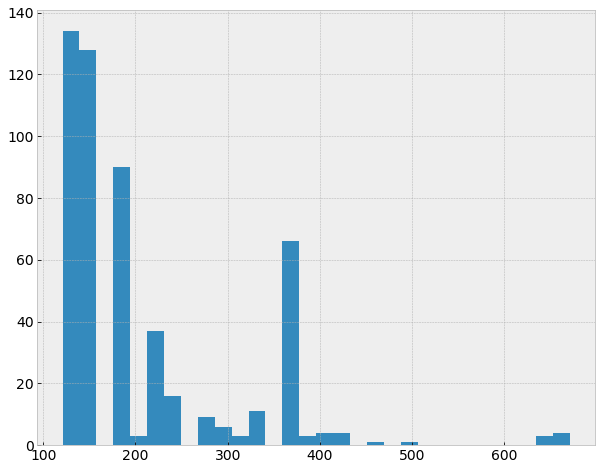

In [122]:
df_final.query('PeriodLength > 120 and PeriodLength < 700').PeriodLength.hist(bins=30)

In [123]:
# Eliminate records with a large number of days in the Billing period
df_final.query('PeriodLength < 450', inplace=True)
df_final.PeriodLength.describe()

count    65410.000000
mean        32.309953
std         17.429088
min          0.000000
25%         30.000000
50%         31.000000
75%         31.000000
max        428.000000
Name: PeriodLength, dtype: float64